# Ejercicio_Análisis y predicción de series temporales con ARMA, SARIMA, SARIMAX.

In [398]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

from math import sqrt

import matplotlib
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [329]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()


    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [330]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

# Parte I

## Importación de datos

In [331]:
df = pd.read_csv("data\Electric_Production.csv")
df.head()

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


Exploremos la producción industrial de servicios públicos de electricidad y gas en los Estados Unidos, desde los años 1985-2018, siendo nuestra frecuencia la producción mensual.

In [332]:
df['DATE'].min()

'1985-01-01'

In [333]:
df['DATE'].max()

'2018-01-01'

## Preprocesamiento de datos

Este paso incluye eliminar las columnas que no necesitamos, verificar los valores faltantes, agregar las ventas por fecha, etc.

In [334]:
df.isnull().sum()

DATE          0
IPG2211A2N    0
dtype: int64

In [335]:
df.index = pd.to_datetime(df.DATE)
df = df.drop(columns=['DATE'])
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [336]:
df.columns = ['Energy_Production']
df.head()

,Energy_Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


## Análisis de los datos

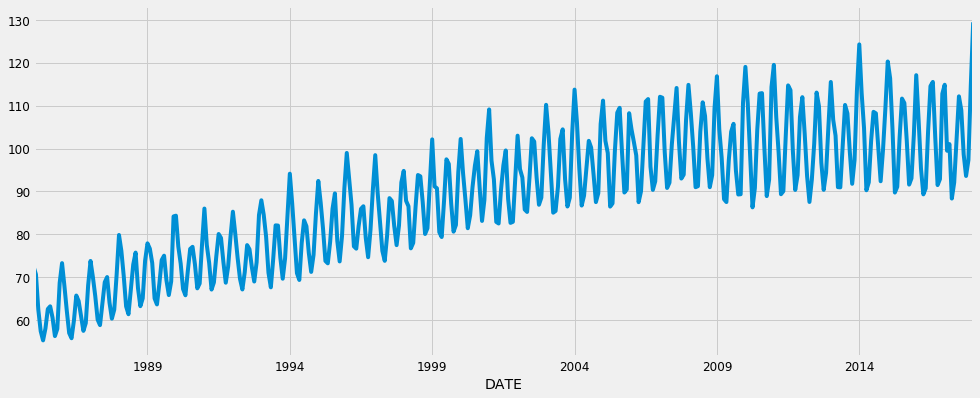

In [399]:
y = df.Energy_Production
y.plot(figsize=(15, 6))
plt.show()

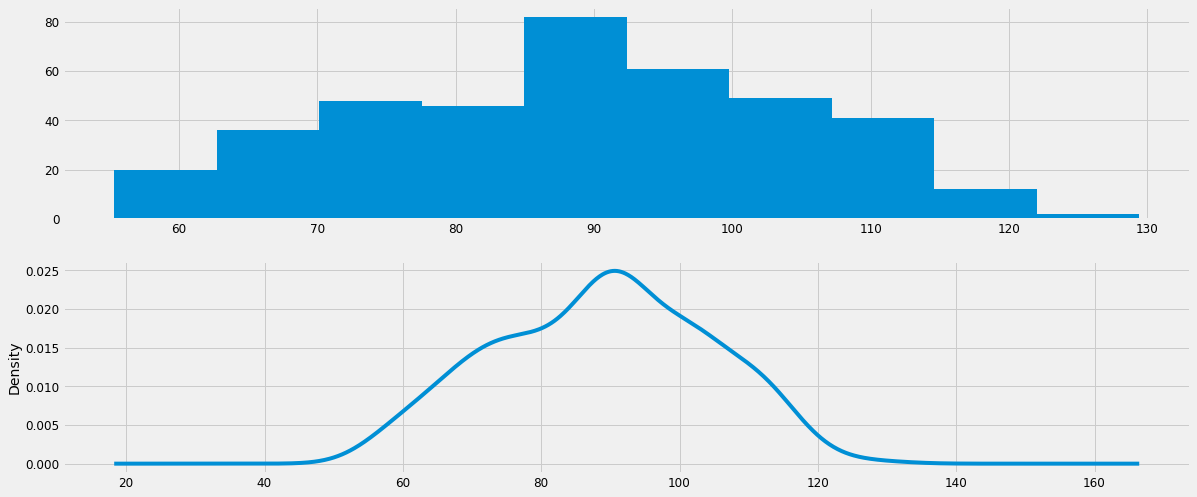

In [338]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.hist()
pyplot.subplot(212)
y.plot(kind='kde')
pyplot.show()

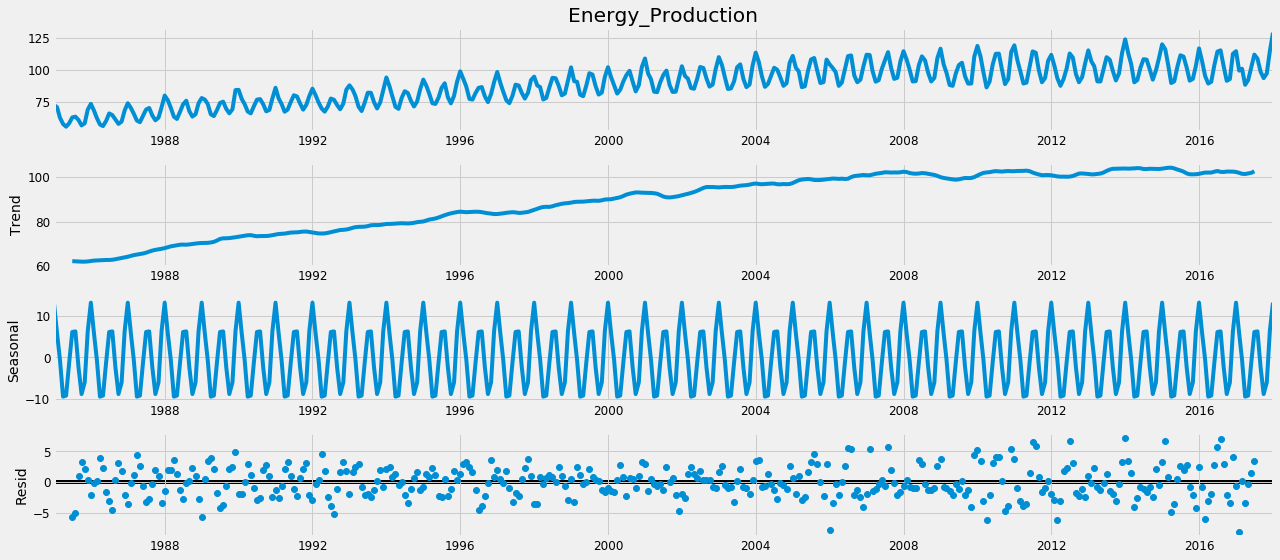

In [400]:

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

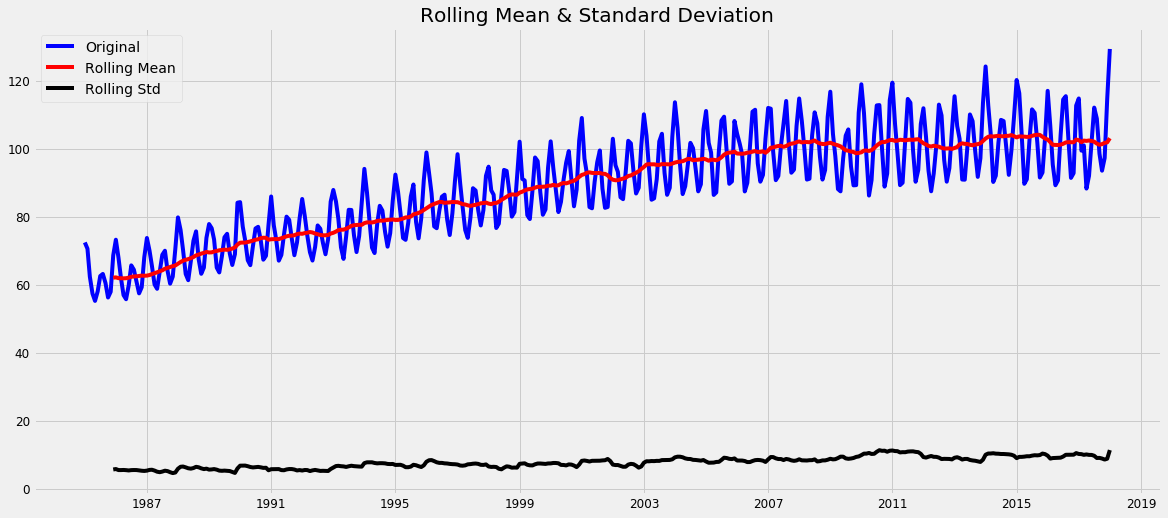

Results of Dickey-Fuller Test:
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [340]:
test_stationarity(y)

En el gráfico de arriba podemos ver claramente el componente estacional de los datos, y también podemos ver la tendencia ascendente separada de los datos.

# Parte II

# Predicción de Series Temporales

## Autoregresión (AR)

In [341]:
from statsmodels.tsa.ar_model import AR
from random import random

# fit model
model = AR(y)
model_fit = model.fit()

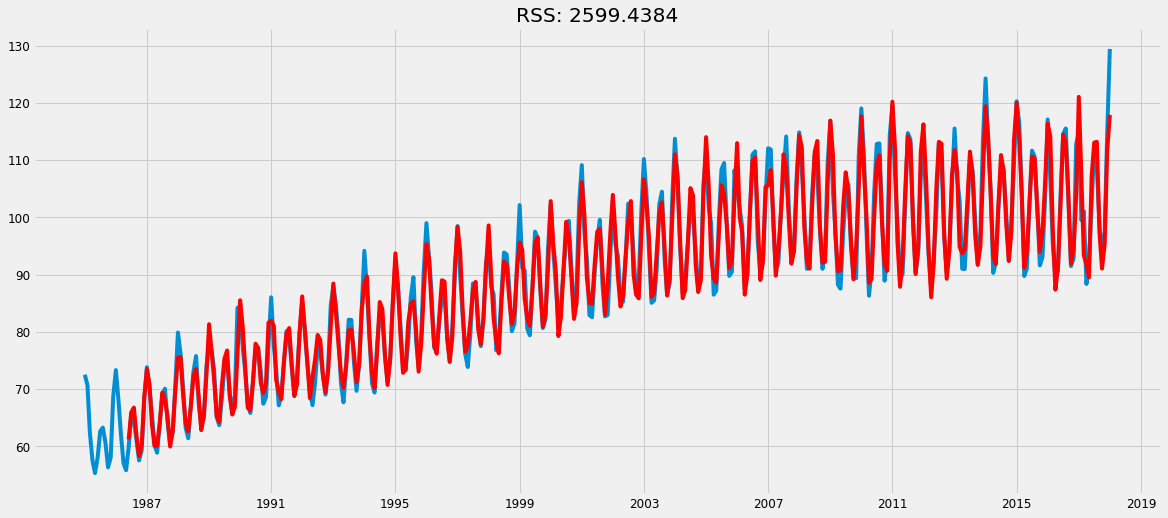

In [342]:
plt.plot(y)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-y)**2))
plt.show()

In [343]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(y, predictions_ARIMA)

666.8380328509322

# Parte III

## Media móvil (MA)

In [403]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(y, order=(0, 1))
model_fit = model.fit(disp=False)

Text(0.5,1,'RSS: 33999.2160')

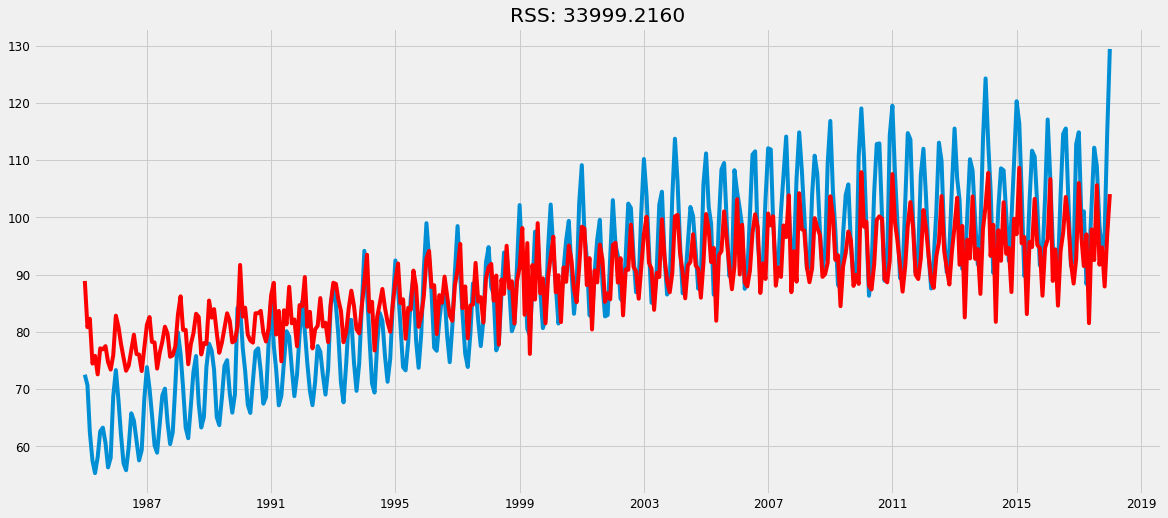

In [404]:
plt.plot(y)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-y)**2))

In [405]:
predictions_MA = pd.Series(model_fit.fittedvalues, copy=True)
evaluate_forecast(y, predictions_MA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.637408,7.573338,6.772357,85.640343,0.011756,9.01532,9.254207


## Media móvil autorregresiva (ARMA)

In [407]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(y, order=(2, 1))
model_fit = model.fit(disp=False)

In [408]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:      Energy_Production   No. Observations:                  397
Model:                     ARMA(2, 1)   Log Likelihood               -1286.499
Method:                       css-mle   S.D. of innovations              6.164
Date:                Mon, 23 Aug 2021   AIC                           2582.998
Time:                        18:41:47   BIC                           2602.918
Sample:                    01-01-1985   HQIC                          2590.889
                         - 01-01-2018                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      89.0455      1.967     45.266      0.000      85.190      92.901
ar.L1.Energy_Production     1.0218      0.068     15.033      0.000       0.889       1.155
ar.L2.Energy_Production    -0.2524      0.066     -3.822      0.000      -0.382      -0.123
ma.L1.Energy_Production     0.4756      0.056      8.474      0.000       0.366       0.586
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6563           +0.0000j            1.6563            0.0000
AR.2            2.3922           +0.0000j            2.3922            0.0000
MA.1           -2.1024           +0.0000j            2.1024            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5,1,'RSS: 15326.0850')

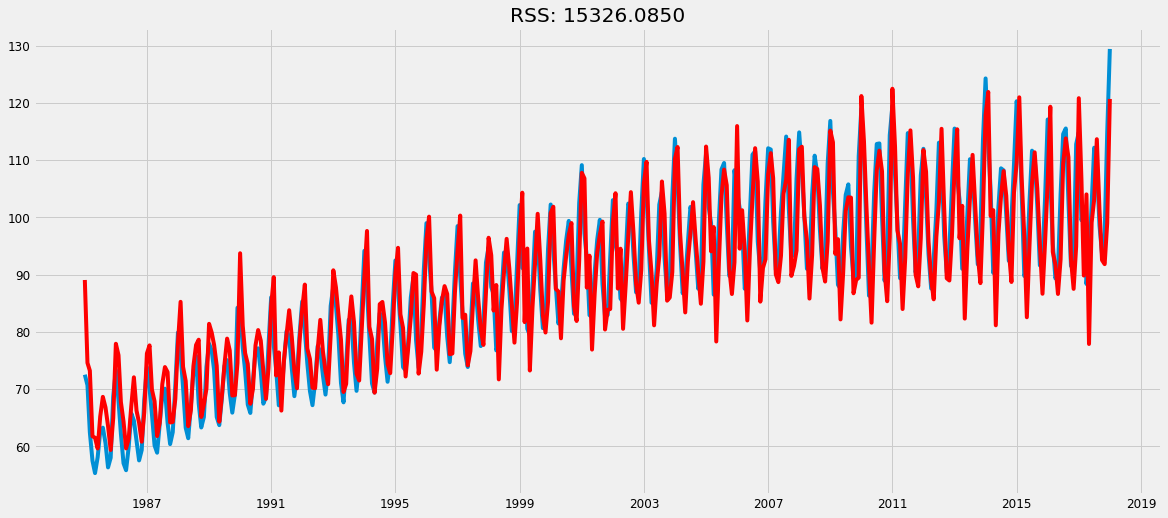

In [409]:
plt.plot(y)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-y)**2))

In [410]:
predictions_ARMA = pd.Series(model_fit.fittedvalues, copy=True)
evaluate_forecast(y, predictions_ARMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.836551,5.059423,4.342989,38.604748,0.004672,5.722625,6.213272


# Parte IV

## Media móvil integrada autorregresiva (ARIMA)


In [449]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=1)

In [450]:
print(model_fit.summary().tables[1])

                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1118      0.020      5.640      0.000       0.073       0.151
ar.L1.D.Energy_Production     0.5356      0.046     11.730      0.000       0.446       0.625
ma.L1.D.Energy_Production    -0.9765      0.010    -98.626      0.000      -0.996      -0.957


In [451]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                              
===============================================================================
Dep. Variable:     D.Energy_Production   No. Observations:                  383
Model:                  ARIMA(1, 1, 1)   Log Likelihood               -1278.478
Method:                        css-mle   S.D. of innovations              6.798
Date:                 Mon, 23 Aug 2021   AIC                           2564.956
Time:                         18:53:58   BIC                           2580.748
Sample:                     02-01-1985   HQIC                          2571.221
                          - 12-01-2016                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1118      0.020      5.640      0.000       0.073       0.151
ar.L1.D.Energy_Production     0.5356      0.046     11.730      0.000       0.446       0.625
ma.L1.D.Energy_Production    -0.9765      0.010    -98.626      0.000      -0.996      -0.957
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8669           +0.0000j            1.8669            0.0000
MA.1            1.0240           +0.0000j            1.0240            0.0000
-----------------------------------------------------------------------------
"""

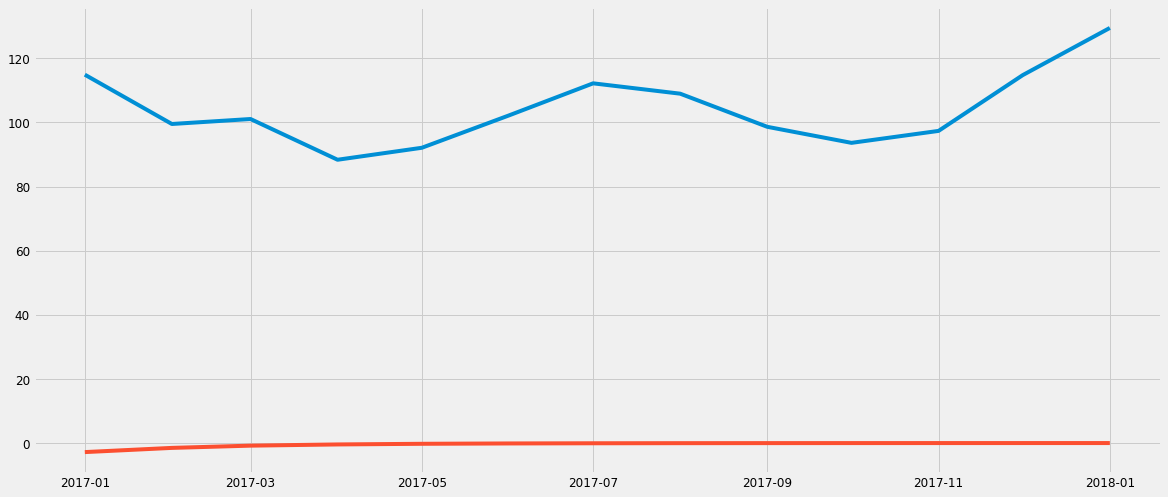

In [452]:
start_index = test.index.min()
end_index = test.index.max()

#Predictions
forecast = model_fit.predict(start=start_index, end=end_index)
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(test, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [454]:
r2_score(y[start_index:end_index], forecast)

-90.3167809550969

# Auto ARIMA

In [446]:
#building the model
#from pyramid.arima import auto_arima
model_auto_arima = auto_arima(train, trace=True)
model_auto_arima.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2651.379, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2593.380, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2523.984, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2649.451, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2524.352, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2427.923, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2395.472, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2347.872, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2347.851, Time=0.22 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2329.279, Time=0.29 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2330.077, Time=0.31 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2258.746, Time=0.38 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2248.117, Time=0.48 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : 

ARIMA(order=(2, 1, 5), scoring_args={}, suppress_warnings=True)

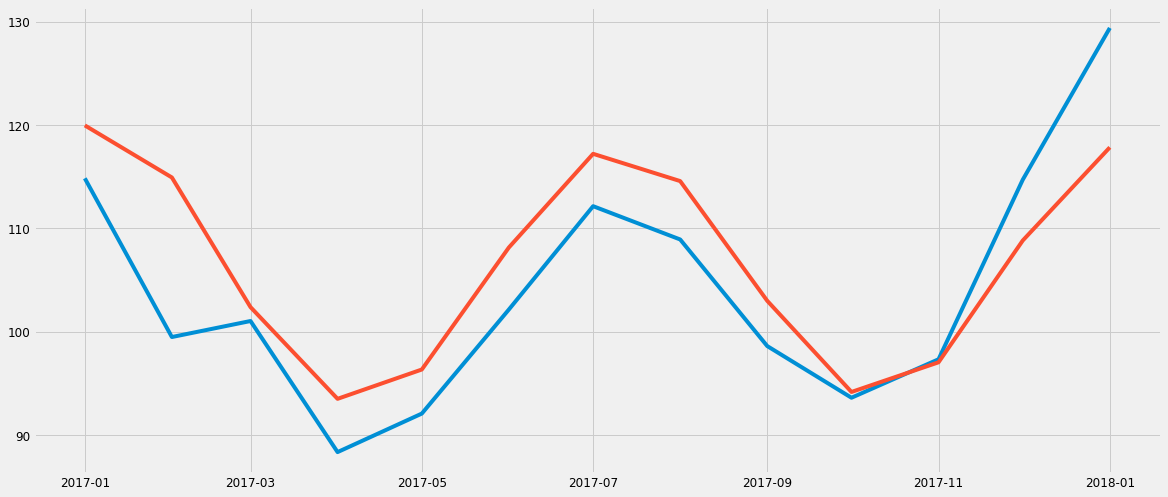

In [447]:
forecast = model_auto_arima.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(test, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [448]:
evaluate_forecast(test, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.622321,5.440738,5.122374,45.598476,0.003731,NaN,6.752664


# Parte V

# AUTO-SARIMA

In [455]:
#building the model
#from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True,
                  seasonal=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2651.379, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2593.380, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2523.984, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2649.451, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2524.352, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2427.923, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2395.472, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2347.872, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2347.851, Time=0.19 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2329.279, Time=0.25 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2330.077, Time=0.31 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2258.746, Time=0.35 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2248.117, Time=0.49 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : 

ARIMA(order=(2, 1, 5), scoring_args={}, suppress_warnings=True)

In [459]:
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
pd.concat([test,forecast],axis=1)

,Energy_Production,Prediction
DATE,,
2017-01-01,114.8505,119.972874
2017-02-01,99.4901,114.932843
2017-03-01,101.0396,102.384896
2017-04-01,88.3530,93.507609
2017-05-01,92.0805,96.345569
2017-06-01,102.1532,108.156130
2017-07-01,112.1538,117.221839
2017-08-01,108.9312,114.582292
2017-09-01,98.6154,102.996721


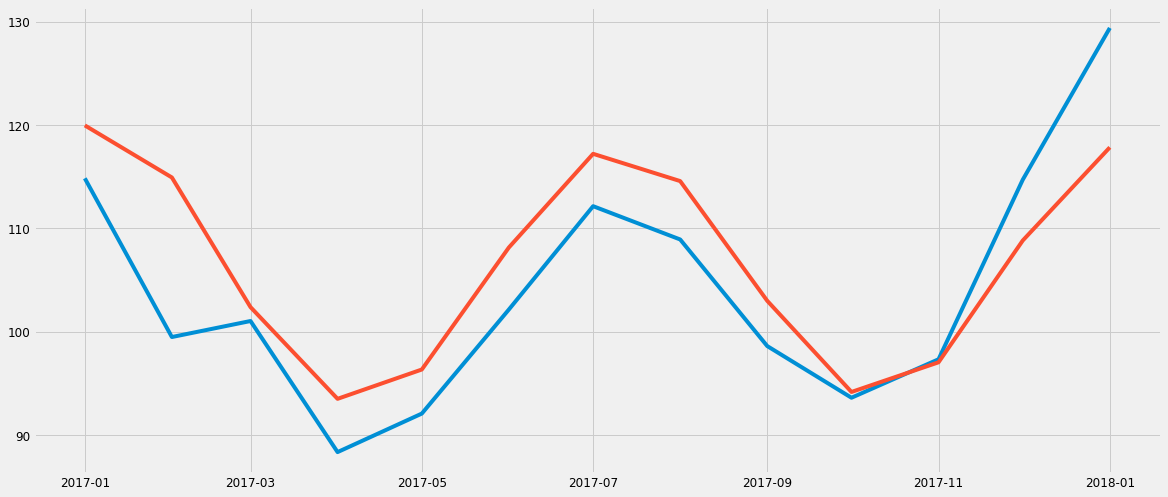

In [460]:
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(test, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [461]:
evaluate_forecast(test, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.622321,5.440738,5.122374,45.598476,0.003731,NaN,6.752664
